## Imports and Read Data

In [50]:
!pip install numpy
!pip install imutils
!pip install opencv-python
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [7]:
from imutils import paths
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
import argparse
import cv2
import os
import shutil
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


## Prepare Data

In [10]:
torch.backends.cudnn.enabled = False

In [11]:
num_epochs = 30
num_classes = 2
batch_size = 5
learning_rate = 0.001

In [12]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8
#Paths
dataset = "/content/keras-covid-19/dataset"
dataset_1 = 'data'
plot = "/content/keras-covid-19/plot.png" 
model = "/content/keras-covid-19/covid19.model"

In [13]:
args={}
args["dataset"]=dataset
args["plot"]=plot
args["model"]=model
args["dataset_1"] = dataset_1

## Data Updates

In [16]:
path, dirs, files2 = os.walk("data/other").__next__()
path, dirs, files1 = os.walk("data/covid").__next__()
print("Number of images in Other: {}".format(len(files2)),"Number of images in Covid: {}".format(len(files1))) 

Number of images in Other: 427 Number of images in Covid: 648


## Load Images

In [17]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset_1"]))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


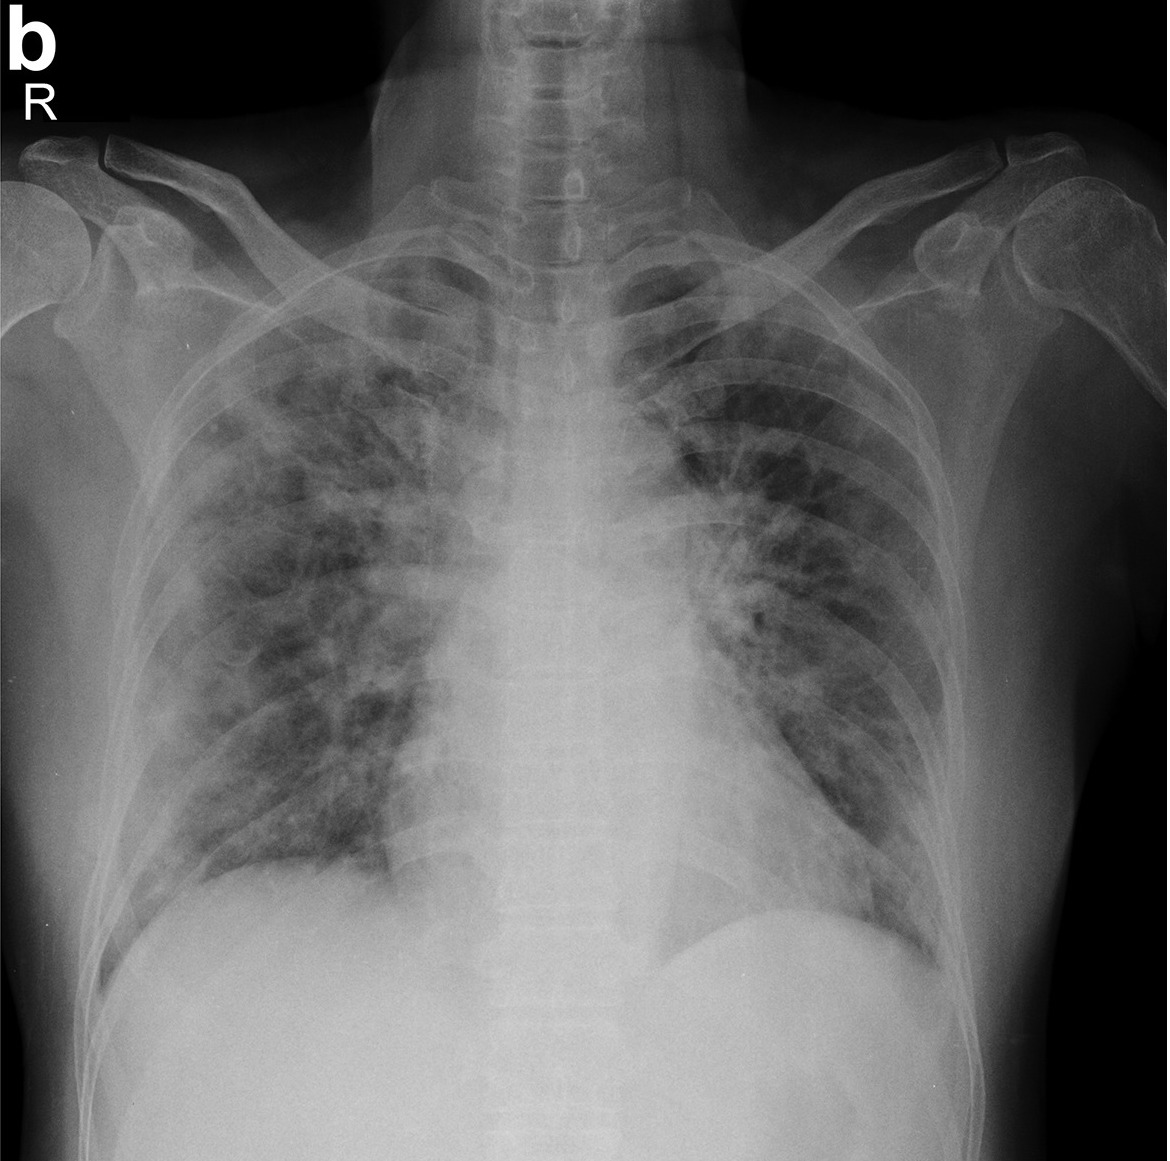

In [18]:
display(Image('covid-chestxray-dataset/images/1-s2.0-S0929664620300449-gr2_lrg-b.jpg',width=420))

In [19]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels); print(labels)


In [20]:
train_y = labels
train_x = data

In [22]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((967, 224, 224), (967,)), ((108, 224, 224), (108,)))

In [23]:
train_x.shape

(967, 224, 224)

In [24]:
#train_x = train_x.reshape(45, 2, 224, 224)
train_x  = torch.from_numpy(train_x)
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([967, 224, 224]), torch.Size([967]))

In [26]:
train_x = train_x.reshape(967, 1, 224, 224)
val_x = val_x.reshape(108, 1, 224, 224)

In [27]:
train_y.shape

torch.Size([967])

In [29]:
val_x  = torch.from_numpy(val_x)
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)
val_x.shape, val_y.shape


(torch.Size([108, 1, 224, 224]), torch.Size([108]))

## CNN Model


In [33]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

In [34]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=0))
        
        self.drop_out = nn.Dropout()

        self.fc1 = nn.Linear(15488, 1000)
        self.fc2 = nn.Linear(1000 ,2)
        
    def forward(self, x):
        x.float()
        #x = x.permute(0,3,1,2)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
       
        return out

In [35]:
print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

torch.Size([967, 1, 224, 224])
torch.Size([108, 1, 224, 224])
torch.Size([967])
torch.Size([108])


In [37]:
model = ConvNet(num_classes).to(device,dtype=float)


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    #if torch.cuda.is_available():
     #   x_train = x_train.cuda()
      #  y_train = y_train.cuda()
       # x_val = x_val.cuda()
        #y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train.long())
    loss_val = criterion(output_val, y_val.long())
    train_losses.append(loss_train.detach())
    val_losses.append(loss_val.detach())
  

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    #if epoch%2 == 0:
        # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
    #wandb.log({"epoch": epoch,"train_loss":loss_train , "val_loss": loss_val})

In [41]:
print(garengaren)

NameError: name 'garengaren' is not defined

In [43]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(0.5429, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  2 	 loss : tensor(0.5588, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(0.5395, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  4 	 loss : tensor(0.5314, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(0.5592, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  6 	 loss : tensor(0.5472, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(0.5360, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  8 	 loss : tensor(0.5170, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(0.5419, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  10 	 loss : tensor(0.5470, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(0.5163, dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  12 	 loss : tensor(0.5180, dtype=torch.float64, grad_fn=<NllLossBackward>)
E

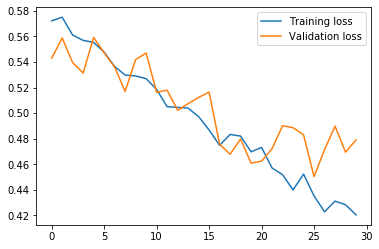

In [44]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [45]:
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

0.7993795243019648

In [46]:
with torch.no_grad():
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

0.7407407407407407

In [48]:
path = "CNNweights2"
torch.save(model.state_dict(), path)

In [49]:
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            },"CNNcheckPoint2" )

In [42]:
checkpoint = torch.load("CNNcheckPoint")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']